# <b>Question 11 - Image Denoising</b>

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
%matplotlib inline

In [2]:
lenaC = cv2.imread("images/corruptedLena.jpg")
lenaC = cv2.cvtColor(lenaC,cv2.COLOR_BGR2GRAY)
lena = cv2.imread("images/lena.jpg")
lena = cv2.cvtColor(lena,cv2.COLOR_BGR2GRAY)
lenaRef = cv2.imread("images/NL.png")
lenaRef = cv2.cvtColor(lenaRef,cv2.COLOR_BGR2GRAY)

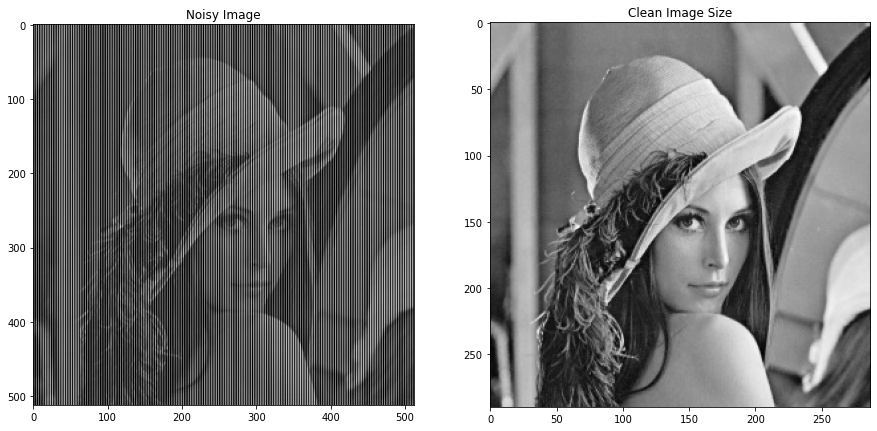

In [3]:
fig, axs = plt.subplots(1, 2, figsize=(15,15))
axs[0].imshow(lenaC,cmap='gray')
axs[0].title.set_text('Noisy Image')
axs[1].imshow(lena,cmap='gray')
axs[1].title.set_text('Clean Image Size')

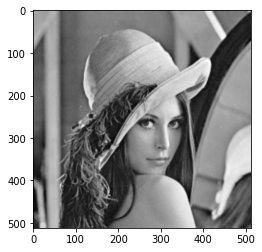

In [4]:
lenaS = cv2.resize(lena,(512,512),cv2.INTER_AREA)
plt.imshow(lenaS,cmap='gray')

In [5]:
def FFT1D(a):
    if a.shape[0]==1:
        return a
    a_odd = a[1::2]
    a_even = a[::2]
    F_odd = FFT1D(a_odd)
    F_even = FFT1D(a_even)
    aFFT = np.zeros(a.shape[0],dtype='complex64')
    out = np.zeros(a.shape[0]//2,dtype='complex64')
    R = np.arange(a.shape[0]//2)
    out = np.exp(-2j*np.pi*R/a.shape[0])
#     out_odd = out*F_odd
#     print(aFFT[:a.shape[0]//2].shape)
#     print(np.array(F_even + out*F_odd).shape)
    aFFT[:a.shape[0]//2] = F_even + out*F_odd
    aFFT[a.shape[0]//2:] = F_even - out*F_odd
    return aFFT.astype('complex64')

In [6]:
def FFT2D(a):
    if a.shape[0]==1:
        return a
    flag1 = abs(np.log2(a.shape[0]) - int(np.log2(a.shape[0])))
    flag2 = abs(np.log2(a.shape[1]) - int(np.log2(a.shape[1])))
    #Row Case
    if flag1!=0:
        #Add zeros
        r_zero = np.zeros((int(2**(np.ceil(np.log2(a.shape[0]))))-a.shape[0],a.shape[1]))
        a = np.append(a,r_zero,axis=0)
    #Col Case
    if flag2!=0:
        #Add zeros
        c_zero = np.zeros((a.shape[0],int(2**(np.ceil(np.log2(a.shape[1]))))-a.shape[1]))
        a = np.append(a,c_zero,axis=1)
    
    out = np.zeros_like(a,dtype='complex64')
    #Row-Wise
    for i in range(a.shape[0]):
        out[i] = FFT1D(a[i])
    #Col-Wise
    for i in range(out.shape[1]):
        out[:,i] = FFT1D(out[:,i])

    return out

In [7]:
def LPF(img,D):
    filt = np.zeros_like(img,dtype='int')
    filD = filt.copy()
    R,C = np.shape(img)
    
    for r in range(R):
        for c in range(C):
            filD[r,c] = np.sqrt(r**2 + c**2)
    
    for i in range(R):
        for j in range(C):
            val = filD[np.abs(i - (img.shape[0]//2)),np.abs(j - (img.shape[1]//2))]
            filt[i,j] = val<=D
    return filt

In [8]:
def InvFFT1D(x):
    s1 = x.copy()
    #Psedo-reverse 1 to N-1
    s1[1:] = s1[:0:-1]
    InvFFT1D = FFT1D(s1)/s1.shape[0]
    return InvFFT1D


In [9]:
def InvFFT2D(a):
    if a.shape[0]==1:
        return a
    out = np.zeros_like(a,dtype='complex64')
    #Row-Wise
    for i in range(a.shape[0]):
        out[i] = InvFFT1D(a[i])
    #Col-Wise
    for i in range(out.shape[1]):
        out[:,i] = InvFFT1D(out[:,i])
    Inv2D = np.real(out)
    return Inv2D

In [10]:
def gaussFilt(img,D):
    filt = np.zeros_like(img,dtype='complex64')
    filD = filt.copy()
    R,C = np.shape(img)
    
    for r in range(R):
        for c in range(C):
            filD[r,c] = np.sqrt(r**2 + c**2)
    
    for i in range(R):
        for j in range(C):
            val = filD[np.abs(i - (img.shape[0]//2)),np.abs(j - (img.shape[1]//2))]
            filt[i,j] = np.exp(-(val**2)/(2*D**2))*img[i,j]
    return filt

In [11]:
print(lenaS.shape)
print(lenaC.shape)

(512, 512)
(512, 512)


In [12]:
lenaCF = FFT2D(lenaC)
lenaF = FFT2D(lenaS)

In [13]:
lenaSF = FFT2D(lenaRef)

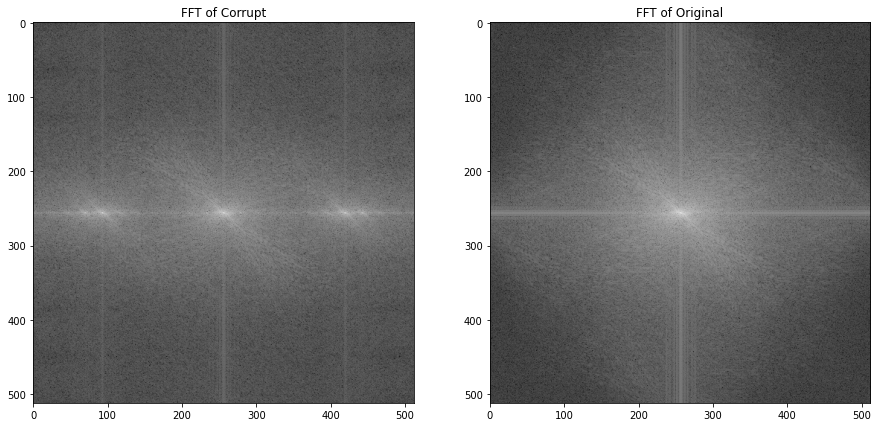

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(15,15))
axs[0].imshow(np.log(1 + np.abs(np.fft.fftshift(lenaCF))), cmap='gray')
axs[0].title.set_text('FFT of Corrupt')
axs[1].imshow(np.log(1 + np.abs(np.fft.fftshift(lenaF))), cmap='gray')
axs[1].title.set_text('FFT of Original')
# axs[1].imshow(np.log(1 + np.abs(np.fft.fftshift(lenaSF))), cmap='gray')
# axs[1].title.set_text('FFT Ref')

In [95]:
qq = lenaCF.copy()
qq[:,160:166] = 0
qq[500:516,130:380] = 0
qq[0:12,130:380] = 0
qq[:,346:352] = 0
for i in range(qq.shape[0]):
    for j in range(qq.shape[1]):
        if i==0:
            if qq[i][j]<5020:
                qq[i][j] = 5020
        if j==0:
            if qq[i][j]<5020:
                qq[i][j] = 5020

In [96]:
rec = InvFFT2D(qq)

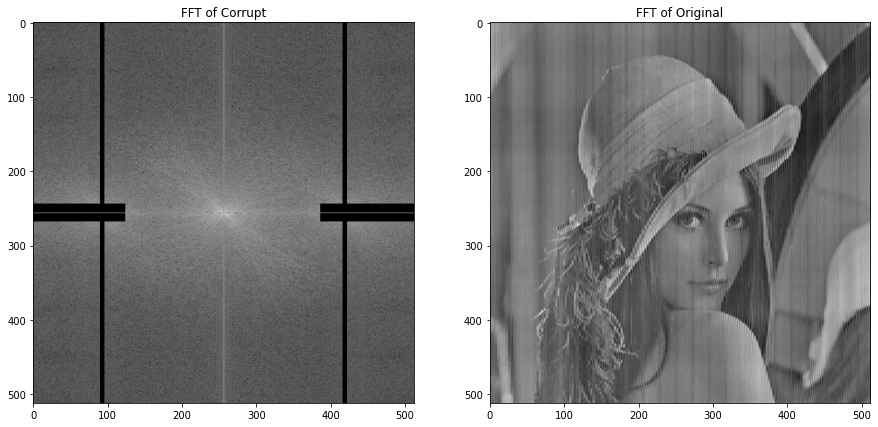

In [97]:
fig, axs = plt.subplots(1, 2, figsize=(15,15))
axs[0].imshow(np.log(1 + np.abs(np.fft.fftshift(qq))), cmap='gray')
axs[0].title.set_text('FFT of Corrupt')
axs[1].imshow(rec, cmap='gray')
axs[1].title.set_text('FFT of Original')

<b>Process</b>:<br>
Essentially we build a band pass filter type of a system for both x and y axis to remove the 2 additional verical lines and also the 3 points on the either side of the x-axis. This is done by first initialising them to 0 and then modifying to match the original existing axis lines. 